In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from tabulate import tabulate
from torch import optim
import torchvision.utils
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split

import config
from utils import imshow
from models import SiameseNetwork, CNN
from training import trainSiamese,inferenceSiamese, trainCNN
from datasets import SiameseNetworkDataset, CNNDataset,generate_csv_compare
from loss_functions import ContrastiveLoss


if not os.path.exists('state_dict'):
    os.makedirs('state_dict')
    
# sys.stdout = open(os.devnull, "w")

In [ ]:
accS = []
accC = []
nums = np.arange(3,10)
for num in nums:
    print("num per class:",num)
    
    accS_temp = []
    accC_temp = []
    for r in range(1,5):
        generate_csv_compare(config.training_dir,config.compare_siamese_csv,config.compare_cnn_csv,config.compare_test_csv,
                             num_per_class = num)

        # Split the dataset into train and validation sets
        siamese_dataset = SiameseNetworkDataset(config.compare_siamese_csv,
                                                transform=transforms.Compose([
                                                    transforms.Resize((config.img_height,config.img_width)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(0,1)]),
                                                should_invert=False)

        num_train = round(0.9*siamese_dataset.__len__())
        num_validate = siamese_dataset.__len__()-num_train



        siamese_train, siamese_valid = random_split(siamese_dataset, [num_train,num_validate])

        siamese_train_dataloader = DataLoader(siamese_train,
                                shuffle=True,
                                num_workers=8,
                                batch_size=config.train_batch_size)

        siamese_valid_dataloader = DataLoader(siamese_valid,
                                shuffle=True,
                                num_workers=8,
                                batch_size=1)

        # Training
        netS = SiameseNetwork().cuda()
        criterionS = ContrastiveLoss()
        optimizer = optim.Adam(netS.parameters(),lr = config.learning_rate )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,config.step_size, config.gamma)

        netS, train_loss_historyS, valid_loss_historyS,dict_nameS = trainSiamese(netS,criterionS,optimizer,scheduler,siamese_train_dataloader,
                     siamese_valid_dataloader,config.train_number_epochs,do_show=False,do_print=False)

        ## Train CNN with Cross Entropy Loss

        cnn_dataset = CNNDataset(config.compare_cnn_csv,
                                                transform=transforms.Compose([
                                                    transforms.Resize((config.img_height,config.img_width)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(0,1)]),
                                                should_invert=False)

        cnn_train_dataloader = DataLoader(cnn_dataset,
                                shuffle=True,
                                num_workers=8,
                                batch_size=config.train_batch_size)

        netC = CNN().cuda()
        criterionC = CrossEntropyLoss()
        optimizer = optim.Adam(netC.parameters(),lr = config.learning_rate )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,config.step_size, config.gamma)

        netC, train_loss_historyC, dict_nameC = trainCNN(netC,criterionC,optimizer,scheduler,cnn_train_dataloader,
                     config.train_number_epochs,do_show=False,do_print=False)

        test_dataset = CNNDataset(config.compare_test_csv,
                                                transform=transforms.Compose([
                                                    transforms.Resize((config.img_height,config.img_width)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(0,1)]),
                                                should_invert=False)

        test_dataloader = DataLoader(test_dataset,
                                shuffle=False,
                                num_workers=1,
                                batch_size=1)
        true_labels = []
        for _,label in iter(test_dataloader):
            true_labels.append(int(label))

        netS = SiameseNetwork().cuda()
        netS.load_state_dict(torch.load(os.path.join("state_dict",dict_nameS)))
        netS.eval()

        siamese_precalculate_dataloader = DataLoader(cnn_dataset,
                                shuffle=False,
                                num_workers=1,
                                batch_size=1)

        feature_vectors = []
        temp = []
        current_label = 0 #int(next(iter(siamese_precalculate_dataloader))[1])
        for data,label in iter(siamese_precalculate_dataloader):
            v = (netS.forward_once(data.cuda()).detach().cpu().numpy())[0]
            if label==current_label:
                temp.append(v)
            else:
                current_label = label
                feature_vectors.append(deepcopy(temp))
                temp = []
                temp.append(v)
        feature_vectors.append(deepcopy(temp))

        inferenceS = []
        for data, label in iter(test_dataloader):
            current_feature = netS.forward_once(data.cuda())
            dissims = []
            temp = 0
            for vectors in feature_vectors:
                for feature in vectors:
                    temp += F.pairwise_distance(current_feature,torch.tensor(feature).cuda()).detach().cpu().numpy()
                dissims.append(temp / len(vectors))
                temp = 0
            inferenceS.append(np.argmin(dissims))

        netC = SiameseNetwork().cuda()
        netC.load_state_dict(torch.load(os.path.join("state_dict",dict_nameC)))
        netC.eval()

        inferenceC = []
        for data, label in iter(test_dataloader):
            current_feature = netC.forward_once(data.cuda())
            inferenceC.append(np.argmax(current_feature.detach().cpu().numpy()))

        accS_temp.append(sum([true_labels[i]==inferenceS[i] for i in range(len(true_labels))])/len(true_labels))
        accC_temp.append(sum([true_labels[i]==inferenceC[i] for i in range(len(true_labels))])/len(true_labels))
    accS.append(deepcopy(accS_temp))
    accC.append(deepcopy(accC_temp))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


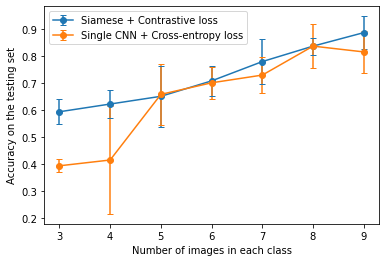

In [12]:
accS_mean = [np.mean(t) for t in accS]
accS_std = [np.std(t) for t in accS]
accC_mean = [np.mean(t) for t in accC]
accC_std = [np.std(t) for t in accC]

fig = plt.figure()
plt.errorbar(nums,accS_mean, yerr=accS_std, fmt='-o',capsize=3)#, color='black',
             #ecolor='lightgray', elinewidth=3, capsize=0);
plt.errorbar(nums,accC_mean, yerr=accC_std, fmt='-o', capsize=3)#, color='black',
            # ecolor='lightgray', elinewidth=3, capsize=0);
plt.xlabel("Number of images in each class")
plt.ylabel("Accuracy on the testing set")
plt.legend(["Siamese + Contrastive loss","Single CNN + Cross-entropy loss"])
fig.savefig('destination_path.eps', format='eps', dpi=1200)

In [ ]:
import numpy